In [1]:
"""
XGBoost multiclassifier for roof materials in D.C.
"""

import os, sys, glob, time
import geopandas as gpd
import pandas as pd
import numpy as np
import rioxarray as rxr
import rasterio as rio
import xgboost as xgb
import gc

from sklearn.ensemble import IsolationForest
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef, accuracy_score

# Functions!
sys.path.append(os.path.join(os.getcwd(),'code/'))
from __functions import *

print(os.getcwd())

# maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/earth-lab/opp-rooftop-mapping'
homedir = '/home/jovyan/data-store/data/iplant/home/maco4303/data/' # cyverse

print("Imports successful!")

/home/jovyan/data-store/opp-rooftop-mapping/code
Imports successful!


In [2]:
# Load the image data

In [3]:
# Load our image data to check on the format
# stack_da_fp = os.path.join(maindir,'data/spatial/mod/dc_data/planet-data/dc_0623_psscene8b_final_norm.tif')
stack_da_fp = os.path.join(homedir,'OPP/planet/dc/dc_0623_psscene8b_final_norm.tif') # cyverse

stack_da = rxr.open_rasterio(stack_da_fp, masked=True, cache=False).squeeze()
print_raster(stack_da, open_file=False)
band_names = list(stack_da.long_name)
print(band_names)
del stack_da

shape: (8223, 6714)
resolution: (3.0, -3.0)
bounds: (315267.0, 4294629.0, 335409.0, 4319298.0)
sum: 8.181640625
CRS: EPSG:32618
NoData: None
['nir', 'NDBIbg', 'NDBIrg', 'NISI', 'MNF1', 'NISI5x5']


In [4]:
# Prep the data columns
band_names_plus = band_names
band_names_plus.append('class_code')
band_names_plus.append('uid')
band_names_plus

['nir', 'NDBIbg', 'NDBIrg', 'NISI', 'MNF1', 'NISI5x5', 'class_code', 'uid']

In [5]:
# Load the training data (footprints)
# gdf_path = os.path.join(maindir,'data/tabular/mod/dc_data/training/dc_data_reference_footprint_sampled.csv')
ref_fp = os.path.join(homedir,'OPP/training/dc/dc_data_reference_footprints_sampled.gpkg')
ref = gpd.read_file(ref_fp)
ref.head()

DriverError: '/home/jovyan/data-store/data/iplant/home/maco4303/data/OPP/training/dc/dc_data_reference_footprints_sampled.gpkg' not recognized as a supported file format.

In [6]:
print(ref['class_code'].value_counts())

class_code
ME    29651
CS    27687
SL    11080
UR     1018
WS      866
TL      617
SH      589
Name: count, dtype: int64


In [7]:
# Merge the misc shingle classes (wood shingle and shingle)
merge = {'WS': 'WSH', 'SH': 'WSH'}
ref['class_code'] = ref['class_code'].replace(merge)
print(ref['class_code'].value_counts())  # Check the counts
gc.collect()

class_code
ME     29651
CS     27687
SL     11080
WSH     1455
UR      1018
TL       617
Name: count, dtype: int64


60

In [8]:
# Create a balanced sample

In [9]:
ref.columns

Index(['field_1', 'class_code', 'areaUTMsqft', 'uid', 'description', 'code',
       'nir', 'NDBIbg', 'NDBIrg', 'NISI', 'MNF1', 'NISI9x9', 'NISI27x27'],
      dtype='object')

In [10]:
# Create a numeric code column
ref['code'], _ = pd.factorize(ref['class_code'])
# Create a dictionary mapping class_code to code
class_mapping = dict(zip(ref['class_code'], ref['code']))
print(class_mapping)

{'CS': 0, 'ME': 1, 'SL': 2, 'UR': 3, 'TL': 4, 'WSH': 5}


In [11]:
# Perform balanced sampling (random undersampling)
ref_bal = balance_sampling(ref, ratio=10, strategy='undersample')
ref_bal.class_code.value_counts()

class_code
ME     6170
CS     6170
SL     6170
WSH    1455
UR     1018
TL      617
Name: count, dtype: int64

In [17]:
X.columns

Index(['nir', 'NDBIbg', 'NDBIrg', 'NISI', 'MNF1', 'NISI9x9', 'NISI27x27',
       'class_code', 'uid'],
      dtype='object')

In [20]:
t0 = time.time()

y = ref_bal['code'] # class code
X = ref_bal[band_names].astype(float) # the image data

# Define dataframes to store results for this feature set
results = pd.DataFrame()  # to store the model performance metrics
feat_imps = pd.DataFrame()  # to store the feature importances
prob_preds = pd.DataFrame()  # for testing optimum cutoff

# Set up the stratified K-fold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Loop the folds
fold_idx = 1
for train_index, test_index in skf.split(X, y):
    t00 = time.time()
    print(f'Fold: {fold_idx}')

    # Split into train/test sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Calculate class weights
    val_counts = list(y_train.value_counts())
    total_samples = sum(val_counts) # total number of samples
    class_weights = [total_samples / count for count in val_counts]
    class_weights = class_weights / np.array(class_weights).sum()     # Normalize the weights
    class_weight_dict = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}
    print(f"Normalized class weights: {class_weights}")
    
    # Map class weights to each sample in the training set
    sample_weights = y_train.map(class_weight_dict).values

    # Initialize the XGBoost classifier for multi-class classification
    xgb_model = xgb.XGBClassifier(
        objective='multi:softmax',
        num_class=len(np.unique(y)),
        n_estimators=1001,
        learning_rate=0.01,
        max_depth=8,
        random_state=42
    )

    # Fit the model
    xgb_model.fit(X_train, y_train, sample_weight=sample_weights)

    # Store feature importance
    fold_imps = pd.DataFrame({
        'Fold': fold_idx,
        'Feature': X.columns,
        'Importance': xgb_model.feature_importances_
    })

    feat_imps = pd.concat([feat_imps, fold_imps], axis=0)

    # Predict on the test set
    y_pred = xgb_model.predict(X_test)

    # Retrieve the accuracy/performance metrics
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted')
    mcc = matthews_corrcoef(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    # Store the metrics into the results data frame
    fold_results = pd.DataFrame({
        'Fold': [fold_idx],
        'Precision': [precision],
        'Recall': [recall],
        'F1': [f1],
        'MCC': [mcc],
        'Accuracy': [accuracy]
    })
    results = pd.concat([results, fold_results], ignore_index=True)

    # Store the probability values for cutoff testing
    y_pred_proba = xgb_model.predict_proba(X_test)

    # Store probabilities and true labels
    fold_probs = pd.DataFrame({
        'TrueLabel': y_test,
        'PredictedProb': list(y_pred_proba),
        'Fold': fold_idx
    })
    prob_preds = pd.concat([prob_preds, fold_probs], ignore_index=True)

    fold_idx += 1

    del fold_probs, fold_results, fold_imps

    t1 = (time.time() - t00) / 60
    print(f"Total elapsed time for fold {fold_idx}: {t1:.2f} minutes.")
    print("\n~~~~~~~~~~\n")

t2 = (time.time() - t0) / 60
print(f"Total elapsed time: {t2:.2f} minutes.")

# # Append the feature set-specific results to the overall results dataframes
# all_results = pd.concat([all_results, results], ignore_index=True)
# all_feat_imps = pd.concat([all_feat_imps, feat_imps], ignore_index=True)
# all_prob_preds = pd.concat([all_prob_preds, prob_preds], ignore_index=True)

# del results, feat_imps, prob_preds

Fold: 1
Normalized class weights: [0.04293355 0.04293355 0.04293355 0.18213141 0.26027294 0.42879499]
Total elapsed time for fold 2: 0.87 minutes.

~~~~~~~~~~

Fold: 2
Normalized class weights: [0.04293355 0.04293355 0.04293355 0.18213141 0.26027294 0.42879499]
Total elapsed time for fold 3: 1.73 minutes.

~~~~~~~~~~

Fold: 3
Normalized class weights: [0.04293355 0.04293355 0.04293355 0.18213141 0.26027294 0.42879499]
Total elapsed time for fold 4: 2.60 minutes.

~~~~~~~~~~

Fold: 4
Normalized class weights: [0.04291258 0.04291258 0.04291258 0.18204243 0.2598621  0.42935774]
Total elapsed time for fold 5: 3.46 minutes.

~~~~~~~~~~

Fold: 5
Normalized class weights: [0.04291258 0.04291258 0.04291258 0.18204243 0.2598621  0.42935774]
Total elapsed time for fold 6: 4.33 minutes.

~~~~~~~~~~

Fold: 6
Normalized class weights: [0.04290637 0.04290637 0.04290637 0.18187715 0.26010815 0.42929561]
Total elapsed time for fold 7: 5.19 minutes.

~~~~~~~~~~

Fold: 7
Normalized class weights: [0.042

In [21]:
results.head()

,Fold,Precision,Recall,F1,MCC,Accuracy
0,1,0.604671,0.431944,0.474587,0.332230,0.431944
1,2,0.596590,0.426852,0.467754,0.323575,0.426852
2,3,0.602312,0.421296,0.462878,0.322503,0.421296
3,4,0.603875,0.412500,0.453011,0.315974,0.412500
4,5,0.598957,0.427315,0.465195,0.327764,0.427315


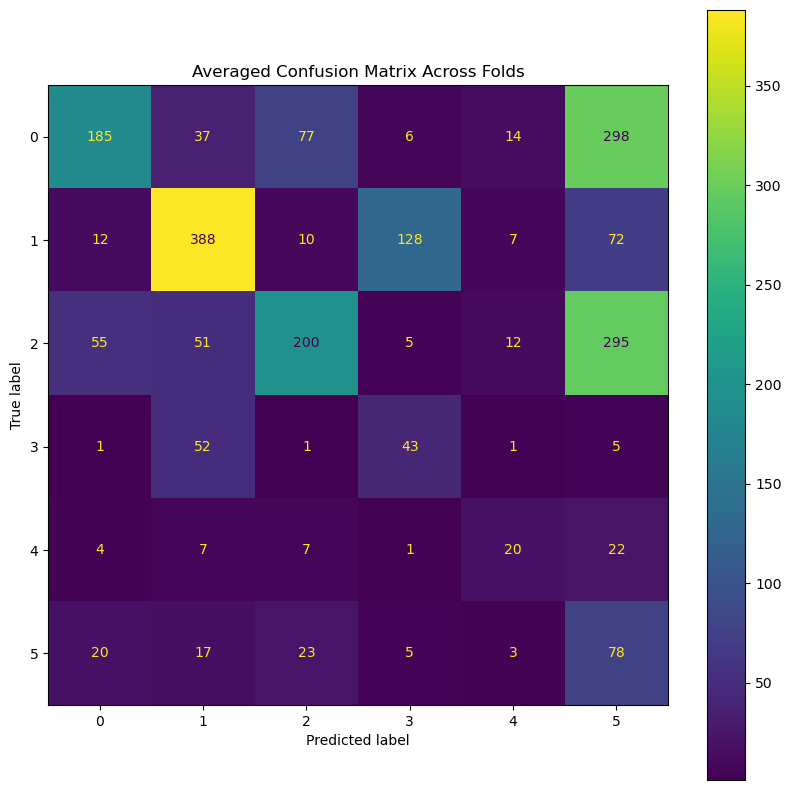

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Initialize the confusion matrix accumulator
n_classes = len(np.unique(y))  # Number of classes
cm_accumulator = np.zeros((n_classes, n_classes))

# Loop over the folds and compute confusion matrices
for fold in range(1, fold_idx):
    fold_data = prob_preds[prob_preds['Fold'] == fold]
    true_labels = fold_data['TrueLabel']
    pred_labels = np.argmax(np.vstack(fold_data['PredictedProb']), axis=1)

    # Compute the confusion matrix for this fold
    cm_fold = confusion_matrix(true_labels, pred_labels, labels=np.unique(y))

    # Accumulate the confusion matrix
    cm_accumulator += cm_fold

# Average the confusion matrix by the number of folds
cm_avg = cm_accumulator / (fold_idx - 1)

# Round to the nearest integer (optional, as you mentioned it's fine)
cm_avg = np.rint(cm_avg).astype(int)

# Display the averaged confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_avg, display_labels=np.unique(y))

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax)
plt.title('Averaged Confusion Matrix Across Folds')

# Save the figure
plt.savefig(os.path.join(maindir, 'figures/FigX_xgboost_confusion_matrix_avg.png'), dpi=300, bbox_inches='tight')

plt.show()

In [23]:
from sklearn.metrics import classification_report

# Create a classification report and convert it to a DataFrame
cor_labels = [label for label, idx in sorted(class_mapping.items(), key=lambda item: item[1])]
cr_df = pd.DataFrame(classification_report(all_true_labels, all_pred_labels, target_names=cor_labels, output_dict=True)).transpose()

# Compute the average accuracy metrics across the 10 folds
average_metrics = cr_df.loc[cor_labels].mean()

# Display the DataFrame
cr_df

,precision,recall,f1-score,support
CS,0.668110,0.300162,0.414225,6170.000000
ME,0.702536,0.628525,0.663473,6170.000000
SL,0.628302,0.323825,0.427380,6170.000000
UR,0.227443,0.418468,0.294708,1018.000000
TL,0.352734,0.324149,0.337838,617.000000
WSH,0.101327,0.535395,0.170404,1455.000000
accuracy,0.422824,0.422824,0.422824,0.422824
macro avg,0.446742,0.421754,0.384671,21600.000000
weighted avg,0.598616,0.422824,0.464941,21600.000000


In [ ]:
# Save out the results
results.to_csv(os.path.join(maindir,'xgboost_folds_results.csv'))
feat_imps.to_csv(os.path.join(maindir,'xgboost_folds_feat_imps.csv'))
prob_preds.to_csv(os.path.join(maindir,'xgboost_folds_prob_peds.csv'))
cr_df.to_csv(os.path.join(maindir,'xgboost_classification_report_avg.csv'))